# Classification on the ‘credit-g’ dataset
### 0. Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
import category_encoders as ce
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

### 1. Determine which features are continuous and which are categorical.

In [2]:
data = pd.read_csv('data/dataset_31_credit-g.csv')

In [3]:
data.head(5)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,'<0',24,'delayed previously','new car',4870,'<100','1<=X<4',3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [4]:
categorical = ["checking_status", "credit_history", "purpose", 
               "savings_status", "employment", "installment_commitment",
               "personal_status", "other_parties", "residence_since", 
               "property_magnitude", "other_payment_plans","housing",
               "existing_credits","job","num_dependents", "own_telephone", 
               "foreign_worker"]

In [5]:
continuous = [i for i in data.columns if i not in categorical + ['class']]

In [6]:
continuous

['duration', 'credit_amount', 'age']

### 2. Visualize the univariate distribution of each continuous feature, and the distribution of the target

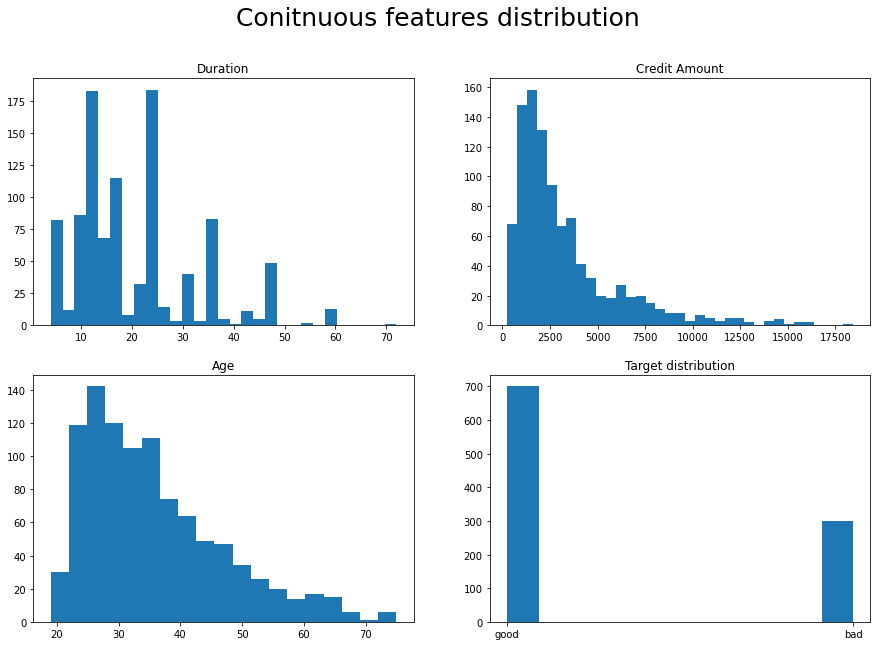

In [7]:
f, ax = plt.subplots(nrows=2,ncols=2,figsize=(15,10))

plt.suptitle('Conitnuous features distribution', fontsize=25)

ax[0,0].hist(data['duration'],bins='auto')
ax[0,0].set_title('Duration')

ax[0,1].hist(data['credit_amount'],bins='auto')
ax[0,1].set_title('Credit Amount')

ax[1,1].hist(data['class'],bins='auto')
ax[1,1].set_title('Target distribution')

ax[1,0].hist(data['age'],bins='auto')
ax[1,0].set_title('Age')


plt.show()

### 3. Split data into training and test set. Do not use the test set until a final evaluation in 1.5.Preprocess the data (such as treatment of categorical variables) without using a pipeline and evaluate an initial LogisticRegression model with an training/validation split.

- Categorical features with more than 4 categories --> target encoding
- Categorical features with less than 5 categories --> onehot encoding
- Continuous features with RobustScaler

In [8]:
data['class'] = data['class'].map({'good':1,'bad':0})

In [9]:
X_train,X_test,y_train,y_test = train_test_split(data.drop(['class'],axis=1),
                                                 data['class'],
                                                 test_size=0.2)

In [10]:
X_train,X_val,y_train,y_val = train_test_split(X_train,
                                               y_train,
                                               test_size=0.2)

In [11]:
target_encoding = []
onehot = []

for cat in categorical:
    if len(X_train[cat].unique()) >= 5:
        target_encoding.append(cat)
    else:
        onehot.append(cat)

In [12]:
te = ce.TargetEncoder(cols=target_encoding)
te.fit(X_train,y_train)

TargetEncoder(cols=['credit_history', 'purpose', 'savings_status',
                    'employment'])

In [13]:
ohe = ce.one_hot.OneHotEncoder(cols=onehot)
ohe.fit(X_train)

OneHotEncoder(cols=['checking_status', 'installment_commitment',
                    'personal_status', 'other_parties', 'residence_since',
                    'property_magnitude', 'other_payment_plans', 'housing',
                    'existing_credits', 'job', 'num_dependents',
                    'own_telephone', 'foreign_worker'])

In [14]:
scaler = RobustScaler()
scaler.fit(X_train[continuous])

RobustScaler()

In [15]:
X_train[continuous] = scaler.transform(X_train[continuous])
X_train = te.transform(X_train)
X_train = ohe.transform(X_train)

X_val[continuous] = scaler.transform(X_val[continuous])
X_val = te.transform(X_val)
X_val = ohe.transform(X_val)

In [16]:
X_train.shape, X_val.shape

((640, 50), (160, 50))

In [17]:
lr = LogisticRegression(max_iter = 10000)
lr.fit(X_train,y_train)
print('Train score:',lr.score(X_train,y_train))
print('Validation score:',lr.score(X_val,y_val))

Train score: 0.76875
Validation score: 0.75


### 4. Use ColumnTransformer and pipeline to encode categorical variables (your choice ofOneHotEncoder or another one from the categorical_encoder package, or both). EvaluateLogistic Regression, linear support vector machines and nearest neighbors usingcross-validation. How different are the results? How does scaling the continuous features with StandardScaler influence the results?

In [18]:
X_train,X_test,y_train,y_test = train_test_split(data.drop(['class'],axis=1),
                                                 data['class'],
                                                 test_size=0.2)

In [19]:
preprocess = ColumnTransformer([('scaler',RobustScaler(),continuous),
                                ('target_encoding',ce.TargetEncoder(cols=target_encoding),target_encoding),
                                ('onehot_encoding',ce.one_hot.OneHotEncoder(cols=onehot),onehot)])

pipe_lr = Pipeline([('Preprocess',preprocess),
                    ('Classifier',LogisticRegression(solver='liblinear'))])

pipe_knn = Pipeline([('Preprocess',preprocess),
                    ('Classifier',KNeighborsClassifier())])

pipe_svc = Pipeline([('Preprocess',preprocess),
                    ('Classifier',SVC())])


cv_lr = cross_val_score(pipe_lr,X_train,y_train)
cv_knn = cross_val_score(pipe_knn,X_train,y_train)
cv_svc = cross_val_score(pipe_svc,X_train,y_train)

print('Scores with SCALER')
print('CV score - LogisticRegression:',cv_lr.mean())
print('CV score - KNN:',cv_knn.mean())
print('CV score - Support vector machine:',cv_svc.mean())

Scores with SCALER
CV score - LogisticRegression: 0.755
CV score - KNN: 0.74375
CV score - Support vector machine: 0.75875


In [20]:
preprocess = ColumnTransformer([('target_encoding',ce.TargetEncoder(cols=target_encoding),target_encoding),
                                ('onehot_encoding',ce.one_hot.OneHotEncoder(cols=onehot),onehot)])

pipe_lr = Pipeline([('Preprocess',preprocess),
                    ('Classifier',LogisticRegression(solver='liblinear'))])

pipe_knn = Pipeline([('Preprocess',preprocess),
                    ('Classifier',KNeighborsClassifier())])

pipe_svc = Pipeline([('Preprocess',preprocess),
                    ('Classifier',SVC())])


cv_lr = cross_val_score(pipe_lr,X_train,y_train)
cv_knn = cross_val_score(pipe_knn,X_train,y_train)
cv_svc = cross_val_score(pipe_svc,X_train,y_train)

print('Scores without SCALER')
print('CV score - LogisticRegression:',cv_lr.mean())
print('CV score - KNN:',cv_knn.mean())
print('CV score - Support vector machine:',cv_svc.mean())

Scores without SCALER
CV score - LogisticRegression: 0.7537499999999999
CV score - KNN: 0.7175
CV score - Support vector machine: 0.7262500000000001


### 5. Tune the parameters using GridSearchCV. Do the results improve? Evaluate only the bemodel on the test set.Visualize the performance as function of the parameters for all three models.

In [21]:
preprocess = ColumnTransformer([('scaler',RobustScaler(),continuous),
                                ('target_encoding',ce.TargetEncoder(cols=target_encoding),target_encoding),
                                ('onehot_encoding',ce.one_hot.OneHotEncoder(cols=onehot),onehot)])

pipe_lr = Pipeline([('Preprocess',preprocess),
                    ('Classifier',LogisticRegression(solver='liblinear'))])

pipe_knn = Pipeline([('Preprocess',preprocess),
                    ('Classifier',KNeighborsClassifier())])

pipe_svc = Pipeline([('Preprocess',preprocess),
                    ('Classifier',SVC())])

params_lr = {'Classifier__penalty': ['l2','l1'],
             'Classifier__C': np.logspace(-3,3,7)}

params_knn = {'Classifier__n_neighbors': [3,5,7,9],
              'Classifier__p': [1,2]}

params_svc = {'Classifier__C': [0.1,1, 10],
              'Classifier__kernel': ['rbf', 'poly', 'sigmoid'],
              'Classifier__gamma': [1,0.1,0.01,0.001]}

search_lr = GridSearchCV(pipe_lr,params_lr)
search_knn = GridSearchCV(pipe_knn,params_knn)
search_svc = GridSearchCV(pipe_svc,params_svc)

In [22]:
search_lr.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('Preprocess',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         RobustScaler(),
                                                                         ['duration',
                                                                          'credit_amount',
                                                                          'age']),
                                                                        ('target_encoding',
                                                                         TargetEncoder(cols=['credit_history',
                                                                                             'purpose',
                                                                                             'savings_status',
                                                                                             'em

In [23]:
search_knn.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('Preprocess',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         RobustScaler(),
                                                                         ['duration',
                                                                          'credit_amount',
                                                                          'age']),
                                                                        ('target_encoding',
                                                                         TargetEncoder(cols=['credit_history',
                                                                                             'purpose',
                                                                                             'savings_status',
                                                                                             'em

In [24]:
search_svc.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('Preprocess',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         RobustScaler(),
                                                                         ['duration',
                                                                          'credit_amount',
                                                                          'age']),
                                                                        ('target_encoding',
                                                                         TargetEncoder(cols=['credit_history',
                                                                                             'purpose',
                                                                                             'savings_status',
                                                                                             'em

In [25]:
print('Best scores\n-------------')
print('LogisticRegression:',search_lr.best_score_,'\nParams:',search_lr.best_params_)
print('\n\nKNN:',search_knn.best_score_,'\nParams:',search_knn.best_params_)
print('\n\nSVC:',search_svc.best_score_,'\nParams:',search_svc.best_params_)

Best scores
-------------
LogisticRegression: 0.7575 
Params: {'Classifier__C': 100.0, 'Classifier__penalty': 'l2'}


KNN: 0.7450000000000001 
Params: {'Classifier__n_neighbors': 9, 'Classifier__p': 2}


SVC: 0.75875 
Params: {'Classifier__C': 1, 'Classifier__gamma': 0.1, 'Classifier__kernel': 'rbf'}


In [26]:
best_model = Pipeline([('Preprocess',preprocess),
                    ('Classifier',LogisticRegression(C=10,penalty='l2',solver='liblinear'))])

best_model.fit(X_train,y_train)
score = best_model.score(X_test,y_test)
print('Score in test set:',score)

Score in test set: 0.745


### 6. Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. Do theparameters that are found change? Do they change if you change the random seed of theshuffling? Or if you change the random state of the split into training and test data?

In [27]:
k_fold = KFold(n_splits=5,shuffle=True)

search_lr = GridSearchCV(pipe_lr,params_lr, cv=k_fold)
search_knn = GridSearchCV(pipe_knn,params_knn, cv=k_fold)
search_svc = GridSearchCV(pipe_svc,params_svc, cv=k_fold)

In [28]:
search_lr.fit(X_train,y_train)
search_knn.fit(X_train,y_train)
search_svc.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('Preprocess',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         RobustScaler(),
                                                                         ['duration',
                                                                          'credit_amount',
                                                                          'age']),
                                                                        ('target_encoding',
                                                                         TargetEncoder(cols=['credit_history',
                                                                                             'purpose',
                                                                                             'savings_status',
                            

In [29]:
print('Best scores with KFold\n----------------')
print('LogisticRegression:',search_lr.best_score_,'\nParams:',search_lr.best_params_)
print('\n\nKNN:',search_knn.best_score_,'\nParams:',search_knn.best_params_)
print('\n\nSVC:',search_svc.best_score_,'\nParams:',search_svc.best_params_)

Best scores with KFold
----------------
LogisticRegression: 0.75125 
Params: {'Classifier__C': 10.0, 'Classifier__penalty': 'l2'}


KNN: 0.74125 
Params: {'Classifier__n_neighbors': 3, 'Classifier__p': 1}


SVC: 0.75125 
Params: {'Classifier__C': 10, 'Classifier__gamma': 0.01, 'Classifier__kernel': 'rbf'}


In [30]:
best_model = Pipeline([('Preprocess',preprocess),
                       ('Classifier',LogisticRegression(C=10,penalty='l1',solver='liblinear'))])

best_model.fit(X_train,y_train)
score = best_model.score(X_test,y_test)
print('Score in test set:',score)

Score in test set: 0.74


### 7. Visualize the 20 most important coefficients for LogisticRegression and Linear SupportVector Machines using hyper-parameters that performed well in the grid-search

In [31]:
te = ce.TargetEncoder(cols=target_encoding).fit(X_train,y_train)
X_train_final = te.transform(X_train)
X_test_final = te.transform(X_test)

scaler = RobustScaler().fit(X_train_final[continuous + target_encoding])
X_train_final[continuous + target_encoding] = scaler.transform(X_train_final[continuous + target_encoding])
X_test_final[continuous + target_encoding] = scaler.transform(X_test_final[continuous + target_encoding])


ohe = ce.one_hot.OneHotEncoder(cols=onehot).fit(X_train_final)
X_train_final = ohe.transform(X_train_final)
X_test_final = ohe.transform(X_test_final)

In [34]:
lr_final = LogisticRegression(C=10,penalty='l1',solver='liblinear')
svc_final = SVC(C=10,gamma=0.01,kernel='rbf')

lr_final.fit(X_train_final,y_train)
svc_final.fit(X_train_final,y_train)

print('20 most important coefficients for LR:\n',\
pd.DataFrame(list(sorted(zip(abs(lr_final.coef_).tolist()[0], X_train_final.columns.tolist()),reverse=True))[:20]))

print('\n\nCoefficients are not available for a SVC using a RBF kernel.')

20 most important coefficients for LR:
            0                         1
0   1.947429        existing_credits_3
1   1.672318          foreign_worker_2
2   0.973469           other_parties_3
3   0.959665                   purpose
4   0.933208         checking_status_2
5   0.874116            savings_status
6   0.737984         checking_status_1
7   0.600993         residence_since_3
8   0.597134  installment_commitment_2
9   0.569658                 housing_2
10  0.527785         personal_status_1
11  0.508363            credit_history
12  0.425700  installment_commitment_3
13  0.409566      property_magnitude_1
14  0.381984     other_payment_plans_2
15  0.368785         checking_status_3
16  0.366410      property_magnitude_4
17  0.357481         residence_since_1
18  0.352155  installment_commitment_1
19  0.316976          num_dependents_1


Coefficients are not available for a SVC using a RBF kernel.
